In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

tf.keras.backend.set_floatx('float32')

In [3]:
from StarKiller.initialization import starkiller_initialize
from StarKiller.interfaces import BurnType, EosType
from StarKiller.integration import Integrator
from StarKiller.network import Network
from StarKiller.eos import Eos
import numpy as np

In [4]:
import multiprocessing as mp

In [5]:
starkiller_initialize("probin_aprox13")
network = Network()
integrator = Integrator()


Initialized StarKiller with ...
- EOS:     helmholtz
- Network: aprox13


In [6]:
class Sample(object):
    def __init__(self, state_in, dt, prediction_type="new"):
        self.state_in = state_in
        self.dt = dt
        
        # Construct a 1D input vector from the input state
        self.flatten_inputs()
        
        # Set the prediction type
        Sample.validate_prediction_type(prediction_type)
        self.prediction_type = prediction_type
    
    @staticmethod
    def validate_prediction_type(prediction_type):
        if not (prediction_type == "new" or
                prediction_type == "delta" or
                prediction_type == "minimal"):
            raise NotImplementedError

    def evaluate(self):
        # Integrate the reaction network through dt to get the output state
        self.state_out = integrator.integrate(self.state_in, self.dt)
        
        # Construct a 1D output "truth" vector from the output state
        # depending on the choice of what quantities we want to predict.
        self.construct_prediction()

    def construct_prediction(self):
        if self.prediction_type == "new":
            self.predict_new()
        elif self.prediction_type == "delta":
            self.predict_deltas()
        elif self.prediction_type == "minimal":
            self.predict_minimal()
        else:
            raise NotImplementedError
        
        self.output_size = self.output_data.size
    
    def flatten_inputs(self):
        self.input_data = np.array([self.dt, self.state_in.state.rho, self.state_in.state.t])
        self.input_data = np.append(self.input_data, self.state_in.state.xn)
        self.input_size = self.input_data.size
        
    def predict_new(self):
        self.output_data = np.array([self.state_out.state.e, self.state_out.state.t])
        self.output_data = np.append(self.output_data, self.state_out.state.xn)
        
    def predict_deltas(self):
        delta_e = self.state_out.state.e
        delta_t = self.state_out.state.t - self.state_in.state.t
        delta_x = self.state_out.state.xn - self.state_in.state.xn
        
        self.output_data = np.array([delta_e, delta_t])
        self.output_data = np.append(self.output_data, delta_x)
        
    def predict_minimal(self):
        # predict only e, t, and X(He-4) from input t alone
        self.output_data = np.array([self.state_out.state.e, self.state_out.state.t])
        
    def scale(self, density_scale = 1.0, temperature_scale = 1.0, energy_scale = 1.0, timestep_scale = 1.0):
        # scale timestep, density, temperature in inputs
        self.input_data[0] /= timestep_scale
        self.input_data[1] /= density_scale
        self.input_data[2] /= temperature_scale
        
        # scale energy and temperature in outputs
        self.output_data[0] /= energy_scale
        self.output_data[1] /= temperature_scale
        
    def reduce_input_dimensions(self, indexes):
        self.input_data = np.array([self.input_data[i] for i in indexes])
        self.input_size = self.input_data.size
        
class SampleSet(object):
    def __init__(self, prediction_type="new"):
        Sample.validate_prediction_type(prediction_type)
        self.prediction_type = prediction_type
        
        self.samples = []
        
    def __iter__(self):
        return iter(self.samples)
    
    def __getitem__(self, item):
        return self.samples[item]

    def create(self, *args):
        self.samples.append(Sample(*args, self.prediction_type))

    def output_size(self):
        if not self.samples:
            raise NotImplementedError
        else:
            return self.samples[0].output_size

    def input_size(self):
        if not self.samples:
            raise NotImplementedError
        else:
            return self.samples[0].input_size

In [7]:
# Input sampling domain & scaling
dens_lo = 1.0e8
dens_hi = 1.0e8
temp_lo = 1.0e8
temp_hi = 1.5e8
xhe_lo = 1.0
xhe_hi = 1.0
dt_lo = 1.0e-6
dt_hi = 1.0e-6

density_scale = dens_lo
temperature_scale = temp_lo
timestep_scale = dt_lo

# do an eos call to set the internal energy scale
eos = Eos()
eos_state = EosType()

# pick a composition for normalization of Ye = 0.5 w/ abar = 12, zbar = 6
eos_state.state.abar = 12.0
eos_state.state.zbar = 6.0
eos_state.state.y_e = eos_state.state.zbar / eos_state.state.abar
eos_state.state.mu_e = 1.0 / eos_state.state.y_e

# use_raw_inputs uses only abar, zbar, y_e, mu_e for the EOS call
# instead of setting those from the mass fractions
eos.evaluate(eos_state.eos_input_rt, eos_state, use_raw_inputs=True)

energy_scale = eos_state.state.e

print("density_scale = ", density_scale)
print("temperature_scale = ", temperature_scale)
print("energy_scale = ", energy_scale)
print("timestep_scale = ", timestep_scale)

density_scale =  100000000.0
temperature_scale =  100000000.0
energy_scale =  8948090280514663.0
timestep_scale =  1e-06


In [8]:
# Construct dataset of training & test samples
samples = SampleSet(prediction_type="minimal")
dataset_size = 10000

for i in range(dataset_size):
    # Randomly construct an input state within the sampling domain
    state_in = BurnType()
    
    ## density & temperature
    state_in.state.rho = np.random.uniform(low=dens_lo, high=dens_hi)
    state_in.state.t = np.random.uniform(low=temp_lo, high=temp_hi)
    
    ## mass fractions
    state_in.state.xn = np.zeros(network.nspec)
    xhe = np.random.uniform(low=xhe_lo, high=xhe_hi)
    state_in.state.xn[:] = (1.0-xhe)/(network.nspec-1)
    state_in.state.xn[network.species_map["he4"]] = xhe
    
    ## ode timestep
    dt = np.random.uniform(low=dt_lo, high=dt_hi)
    
    # Create a sample without evaluating yet
    samples.create(state_in, dt)
    
for s in samples:
    s.evaluate()

In [9]:
def pool_get_samples():
    # this doesn't seem to work quite right yet ... or maybe just not within the notebook??
    pool = mp.Pool()

    evaluated_samples = []

    def append_to_list(s):
        evaluated_samples.append(s)

    def evaluate_sample(s):
        s.evaluate()
        return s

    for i in range(len(samples.samples)):
        pool.apply_async(evaluate_sample, args=(samples.samples[i],), callback=append_to_list)

    pool.close()
    pool.join()

    samples.samples = evaluated_samples

In [10]:
# Rescale the samples
for s in samples:
    s.scale(density_scale=density_scale,
            temperature_scale=temperature_scale,
            energy_scale=energy_scale/100.0,
            timestep_scale=timestep_scale)
    s.reduce_input_dimensions([2])

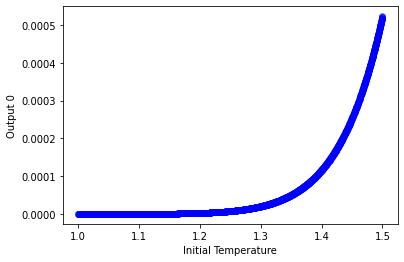

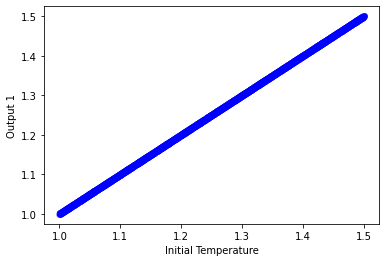

In [11]:
# Plot each input & output value vs input temperature
input_temp = np.array([s.input_data[0] for s in samples])

# This index i goes into the outputs
for i in range(samples.output_size()):
    output_string_i = ""
    ode_out_i = np.array([s.output_data[i] for s in samples])
    
    fig, axis = plt.subplots()
    
    axis.scatter(input_temp, ode_out_i, color='blue', alpha=0.1)
    
    axis.set_ylabel("Output {}".format(i))
    axis.set_xlabel("Initial Temperature")

In [12]:
# Separate sample dataset into training & testing samples
train_input_data = []
train_output_data = []

test_input_data = []
test_output_data = []

randomly_sort_samples = False

if randomly_sort_samples:
    for s in samples:
        x = np.random.uniform()
        if x > 0.2:
            train_input_data.append(s.input_data)
            train_output_data.append(s.output_data)
        else:
            test_input_data.append(s.input_data)
            test_output_data.append(s.output_data)
else:
    train_input_data = [s.input_data for s in samples[:-5]]
    train_output_data = [s.output_data for s in samples[:-5]]
    test_input_data = [s.input_data for s in samples[-5:]]
    test_output_data = [s.output_data for s in samples[-5:]]
        
train_input_data = np.array(train_input_data)
train_output_data = np.array(train_output_data)

test_input_data = np.array(test_input_data)
test_output_data = np.array(test_output_data)

print("training input data is of shape: ", np.shape(train_input_data))
print("training output data is of shape: ", np.shape(train_output_data))
print("test input data is of shape: ", np.shape(test_input_data))
print("test output data is of shape: ", np.shape(test_output_data))

training input data is of shape:  (9995, 1)
training output data is of shape:  (9995, 2)
test input data is of shape:  (5, 1)
test output data is of shape:  (5, 2)


In [13]:
def build_model():
    # this specifies the input to the first hidden layer (same number of nodes as a sample input shape)
    # then an additional hidden layer with 128 nodes
    # then the output layer with nspec+2 nodes
    model = keras.Sequential([
        layers.Dense(3+network.nspec, activation='sigmoid', input_shape=(samples.input_size(),), dtype='float32'),
        layers.Dense(128, activation='sigmoid', dtype='float32'),
        layers.Dense(samples.output_size(), dtype='float32')
    ])
    
    # this is gradient descent, and it multiplies the gradient by learning_rate to get
    # the weight updates. Without momentum the update is:
    # (no momentum): w = w - learning_rate * gradient
    # (momentum):
    ###   velocity = momentum * velocity - learning_rate * gradient
    ## (momentum w/ nesterov):
    ###   w = w * velocity
    ## (momentum w/o nesterov):
    ###   w = w + momentum * velocity - learning_rate * gradient
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.5, nesterov=True)
    
    #optimizer = tf.keras.optimizers.Adam()
    
    model.compile(loss=tf.keras.losses.MeanAbsolutePercentageError(),
                  optimizer=optimizer,
                  metrics=[tf.keras.metrics.MeanSquaredError(),
                           tf.keras.metrics.MeanAbsolutePercentageError()])
    return model

In [14]:
model = build_model()

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                32        
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2176      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 2,466
Trainable params: 2,466
Non-trainable params: 0
_________________________________________________________________


In [16]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Percentage Error')
    plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
    plt.legend()
    plt.show()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.legend()
    plt.show()

In [17]:
def KerasFitModel():
    # Stop early by monitoring loss for the validation ensemble
    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)
    
    # Display training progress by printing a single dot for each completed epoch
    class PrintDot(keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs):
            if epoch % 100 == 0:
                print('.', end='')
            if epoch % 1000 == 0:
                print('')

    history = model.fit(train_input_data, train_output_data, batch_size=100000, verbose=0,
                        epochs=10000, validation_split=0.2, callbacks=[PrintDot(), early_stop])

    plot_history(history)

In [18]:
def CustomFitModel():
    dataset = tf.data.Dataset.from_tensor_slices((train_input_data, train_output_data)).batch(1)
    
    for input, target in dataset:
        print("shape of input: ", tf.shape(input))
        print("shape of target: ", tf.shape(target))
        with tf.GradientTape(persistent=True) as tape:
            prediction = model(input)
            
            # calculate loss
            # error 1: y_pred = y_true
            Error1 = tf.reduce_mean(tf.square(target - prediction))
            
        gradients1 = tape.gradient(Error1, model.trainable_weights)
        print("shape of error1: ", tf.shape(Error1))
        
        #print("shape of gradients1: ", tf.shape(gradients1))
        
        
        dpred_dinput = tape.gradient(prediction, input)
        print("shape of dpred_dinput: ", tf.shape(dpred_dinput))
        
        #dpred_dinput_array = tf.make_ndarray(dpred_dinput)
        
        # error 2: d(y_pred)/dt = F(y_true)
        del tape
        break

.
.

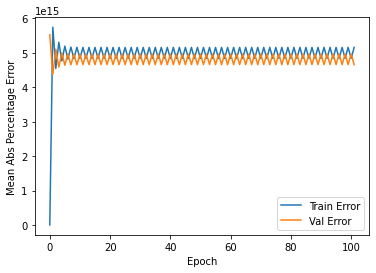

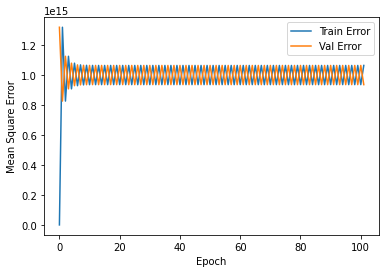

In [19]:
KerasFitModel()

In [20]:
def plot_prediction_truth(test_input_data, test_output_data):
    test_predictions = model.predict(test_input_data)

    test_predictions = np.transpose(test_predictions)
    test_truth = np.transpose(test_output_data)

    for i, (predicted, truth) in enumerate(zip(test_predictions, test_truth)):
        fig, axis = plt.subplots()
        axis.scatter(truth, predicted)
        axis.set_xlabel("truth")
        axis.set_ylabel("prediction")
        axis.axis("equal")
        axis.axis("square")
        plt.savefig("truth_map_{}.png".format(i))

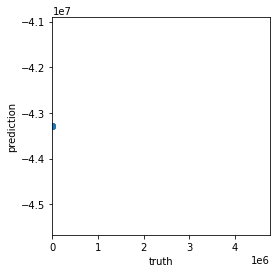

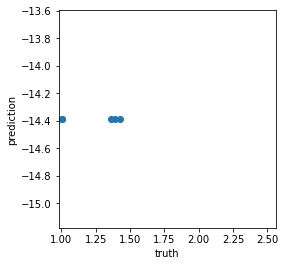

In [21]:
plot_prediction_truth(test_input_data, test_output_data)